In [3]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(1234)
import matplotlib.pyplot as plt
import cv2

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
# Assemble dataset
def get_matrices():
    data = []
    labels = []
    
    for i in list(range(1, 6)):
        xx, yy = load_batch(i)
        xx, yy = preprocess(xx, yy)
        data.append(xx)
        labels.append(yy)
    
    x_tr = np.concatenate(data)
    y_tr = np.concatenate(labels)

    x_te, y_te = load_batch(999, test=True)
    x_te, y_te = preprocess(x_te, y_te)

    print('x_tr shape: '+ str(x_tr.shape))
    print('y_tr shape: '+ str(y_tr.shape))
    print('\nx_tr dtype: '+ str(x_tr.dtype))
    print('y_tr dtype: '+ str(y_tr.dtype))
    print('\nx_te shape: '+ str(x_te.shape))
    print('y_te shape: '+ str(y_te.shape))
    print('\nx_te dtype: '+ str(x_te.dtype))
    print('y_te dtype: '+ str(y_te.dtype))  
    
    return x_tr, y_tr, x_te, y_te
    
# Load dataset from memory
def load_batch(i, test = False):
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    d = {}
    if test:
        d = unpickle('./cifar-10-batches-py/test_batch')
    else:
        d = unpickle('./cifar-10-batches-py/data_batch_'+str(i))
    
    return d[b'data'], d[b'labels']

In [6]:
# Pre-process functions here 

# Assemble pre-processes
def preprocess(x, y):
    
    # ohe
    y = OneHotEncoder().fit_transform(np.array(y).reshape(-1,1)).toarray()
    
    # reshape x
    x = x.reshape((x.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    
    # as float16
    x = x.astype('float64')
    y = y.astype('float16')
    
    # normalize
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    
    return x, y

In [7]:
# Common functions

def plot_history(hist):
    fig=plt.figure()
    ax=fig.add_subplot(121)
    bx=fig.add_subplot(122)
    ax.plot(hist.history['loss'],label='loss')
    ax.plot(hist.history['val_loss'],label='val_loss')
    ax.set_title('loss')
    ax.legend()
    bx.plot(hist.history['accuracy'],label='accuracy')
    bx.plot(hist.history['val_accuracy'],label='val_accuracy')
    bx.set_title('accuracy')
    bx.legend()

In [8]:
x_tr, y_tr, x_te, y_te = get_matrices()

x_tr shape: (50000, 32, 32, 3)
y_tr shape: (50000, 10)

x_tr dtype: float64
y_tr dtype: float16

x_te shape: (10000, 32, 32, 3)
y_te shape: (10000, 10)

x_te dtype: float64
y_te dtype: float16


Text(0.5, 1.0, '7')

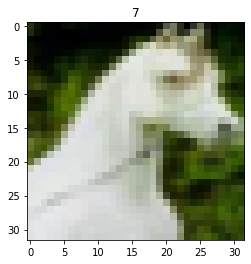

In [9]:
ind = np.random.randint(0,50000)
plt.imshow((255*x_tr[ind]).astype('int'))
plt .title(y_tr[ind].argmax())

### Attempt 1

In [86]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3)),
    tf.keras.layers.Conv2D(16, (1,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation= tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation= tf.keras.activations.softmax)
])

In [87]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [88]:
model.fit(x, y, epochs=3, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 22s 545us/sample - loss: 4.0366 - accuracy: 0.0969 - val_loss: 2.3041 - val_accuracy: 0.0997
Epoch 2/3
40000/40000 [==============================] - 25s 613us/sample - loss: 2.3039 - accuracy: 0.0994 - val_loss: 2.3034 - val_accuracy: 0.1025
Epoch 3/3
40000/40000 [==============================] - 26s 655us/sample - loss: 2.3039 - accuracy: 0.0990 - val_loss: 2.3035 - val_accuracy: 0.0977


### Attempt 2

In [10]:
class BasicModel(tf.keras.Model):

    def __init__(self):
        super(BasicModel, self).__init__()
        
        # Block 1
        self.c11  = tf.keras.layers.Conv2D(35, (3,3))
        self.c12  = tf.keras.layers.Conv2D(40, (3,3))
        self.m11 = tf.keras.layers.MaxPool2D()
        self.c13  = tf.keras.layers.Conv2D(40, (1,1))
        
        # Block 2
        self.c21 = tf.keras.layers.Conv2D(40, (3,3))
        self.c22 = tf.keras.layers.Conv2D(40, (3,3))
        self.m21 = tf.keras.layers.MaxPool2D()
        self.c23  = tf.keras.layers.Conv2D(50, (1,1))
        
        # Dense Block
        self.f31 = tf.keras.layers.Flatten()
        self.d31 = tf.keras.layers.Dense(146, activation= tf.keras.activations.relu)
        self.d32 = tf.keras.layers.Dense(81, activation= tf.keras.activations.relu)
        self.d33 = tf.keras.layers.Dense(10, activation= tf.keras.activations.softmax)

    def call(self, inputs):
        
        # Block 1
        x1 = self.c11(inputs)
        x1 = self.c12(x1)
        x1 = self.m11(x1)
        x1 = self.c13(x1)
        
        # Block 2
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x1)
        x2 = self.c21(x2)
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x2)
        x2 = self.c22(x2)     
        x2 = self.m21(x2)
        x2 = self.c23(x2)
        
        # Dense Block 
        x3 = self.f31(x2)
        x3 = self.d31(x3)
        x3 = self.d32(x3)
        x3 = self.d33(x3)
        
        return x3

In [15]:
model = BasicModel()

optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
loss=tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer,loss,metrics=['accuracy'])

In [16]:
model.build((None, 32, 32, 3))
model.summary()

Model: "basic_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            multiple                  980       
_________________________________________________________________
conv2d_7 (Conv2D)            multiple                  12640     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  1640      
_________________________________________________________________
conv2d_9 (Conv2D)            multiple                  14440     
_________________________________________________________________
conv2d_10 (Conv2D)           multiple                  14440     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                

In [17]:
hist = model.fit(x_tr, y_tr, epochs= 20, validation_data= (x_te, y_te))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 50s 1ms/sample - loss: 1.4980 - accuracy: 0.4667 - val_loss: 1.2730 - val_accuracy: 0.5530
Epoch 2/20
50000/50000 [==============================] - 52s 1ms/sample - loss: 1.1670 - accuracy: 0.5989 - val_loss: 1.1040 - val_accuracy: 0.6276
Epoch 3/20
50000/50000 [==============================] - 55s 1ms/sample - loss: 1.0693 - accuracy: 0.6321 - val_loss: 1.1229 - val_accuracy: 0.6140
Epoch 4/20
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.0048 - accuracy: 0.6587 - val_loss: 1.0964 - val_accuracy: 0.6412
Epoch 5/20
50000/50000 [==============================] - 62s 1ms/sample - loss: 0.9560 - accuracy: 0.6776 - val_loss: 1.1294 - val_accuracy: 0.6309
Epoch 6/20
50000/50000 [==============================] - 63s 1ms/sample - loss: 0.9254 - accuracy: 0.6899 - val_loss: 1.1056 - val_accuracy: 0.6339
Epoch 7/20
50000/50000 [==============================] 

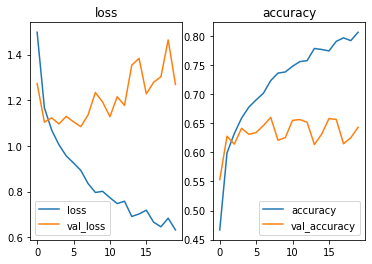

In [18]:
plot_history(hist)

### Attempt 3